# Zeus21 with Population II and III Stars

This quick tutorial covers all the new features in the updated public version of Zeus21 (see our paper [Cruz et al. 2024](https://arxiv.org/abs/2407.18294)) for more information.

In this new version, we have included the influence of Population III stars as well as the suppressive feedback effects from Lyman-Werner radiation and the relative velocity between CDM and baryons.

In [1230]:
import math
import numpy as np
from matplotlib import pyplot as plt

#import Zeus
import zeus21

#set up the CLASS cosmology
from classy import Class

#and the user parameters
UserParams = zeus21.User_Parameters(precisionboost=1.2)


## Step 1: Set up Cosmology

We begin by running CLASS, where the associated parameters can be altered below. Then we save the cosmo parameters, the correlation functions, and the halo mass function at all desired z and M.

In [1231]:
# cosmo inputs from table 2 last column of 1807.06209, as 21cmFAST
ombh2 = 0.02242 
omch2 = 0.11933
tau_re = 0.0544
hLittle = 0.6766
ns = 0.9665
As = np.exp(3.047)*10**(-10.)


In [1232]:
#set up your input CLASS parameters here
#note; VCB feedback is turned on as the USE_RELATIVE_VELOCITIES flag in CosmoParams_input

CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omch2, omegab = ombh2, h_fid = hLittle, As = As, ns = ns, tau_fid = tau_re, USE_RELATIVE_VELOCITIES = True, Flag_emulate_21cmfast=False)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [1233]:
#define all cosmology (including derived) parameters, and save them to the CosmoParams structure
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 

#Generate and store the matter correlation function
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)
print('Correlation functions saved.')

# Compute the HMF structure that stores associated quantities
HMFintclass = zeus21.HMF_interpolator(UserParams, CosmoParams, ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')


Correlation functions saved.
HMF interpolator built. This ends the cosmology part -- moving to astrophysics.


## Step 2: Astrophysics

After that we set up the astro parameters, calculate the SFRD and with it all the global signal and related quantities. In principle one can re-run the astrophysics part only if you're certain of the cosmology parameters. 

With the current implementation, the computation of global quantities below takes less than a second on a laptop.

For more details on parameters, please refer to those used in Table 1 of our paper linked above.

NOTE: Pop III stars and LW feedback are turned on using the USE_POP_III and USE_LW_FEEDBACK flags below.

In [1234]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0 
betastar_III = 0
fstar_III = [10**(-0), 10**(-1.0), 10**(-2.0), 10**(-3.0), 10**(-4.0), 10**(-5.0), 10**(-6.0), 10**(-7.0)]
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35), 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8


#set up your astro parameters too, here the peak of f*(Mh) as an example
list1 = []

for i in range(len(fstar_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III[i],
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list1.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')

SFRD and coefficients stored. Move ahead.


In [1235]:
zlist= list1[0].zintegral

## Step 3: Plotting globally-averaged quantities

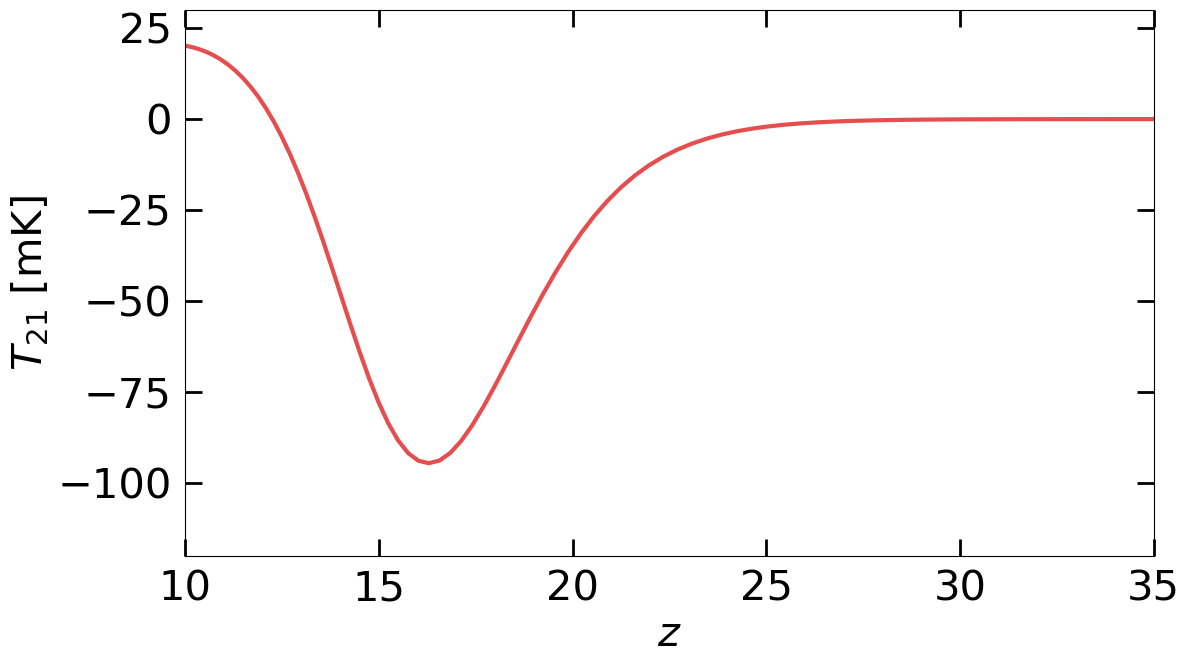

In [1236]:
plt.figure(figsize = (12, 6.75))

plt.plot(zlist, CoeffStructure.T21avg, color = "#E64D4E", linewidth = 3)

plt.xlim([10, 35])
plt.ylim([-120, 30])

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$T_{21}$ [mK]', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)

plt.tight_layout()

plt.show()

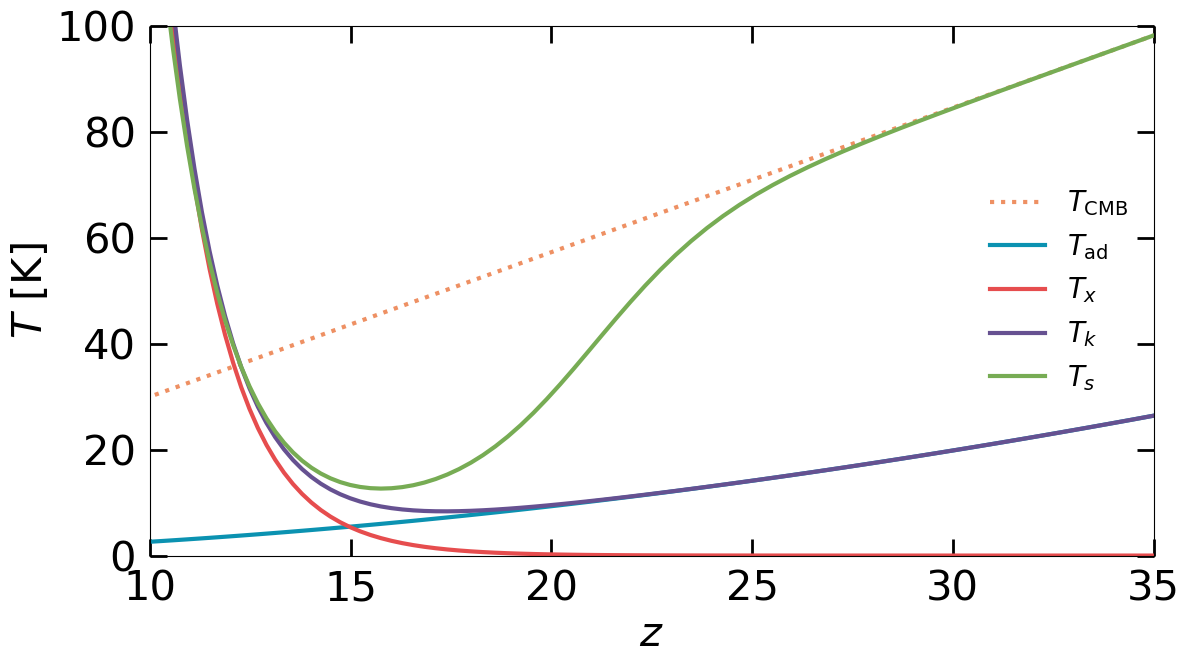

In [1237]:
plt.figure(figsize = (12, 6.75))

plt.plot(zlist,CoeffStructure.T_CMB , color = "#EE9063", linewidth = 3, linestyle = 'dotted', label = r'$T_\mathrm{CMB}$')


plt.plot(zlist,CoeffStructure.Tk_ad , color = "#0B92B1", linewidth = 3, label = r'$T_\mathrm{ad}$')
plt.plot(zlist,CoeffStructure.Tk_xray , color = "#E64D4E", linewidth = 3, label = r'$T_x$')
plt.plot(zlist,CoeffStructure.Tk_avg, color = "#665191", linewidth = 3, label = r'$T_k$')

plt.plot(zlist,CoeffStructure._invTs_avg**-1 , color = "#77AC54", linewidth = 3, label = r'$T_s$')


plt.xlim([10, 35])
plt.ylim([0, 100])

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$T$ [K]', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()

plt.show()

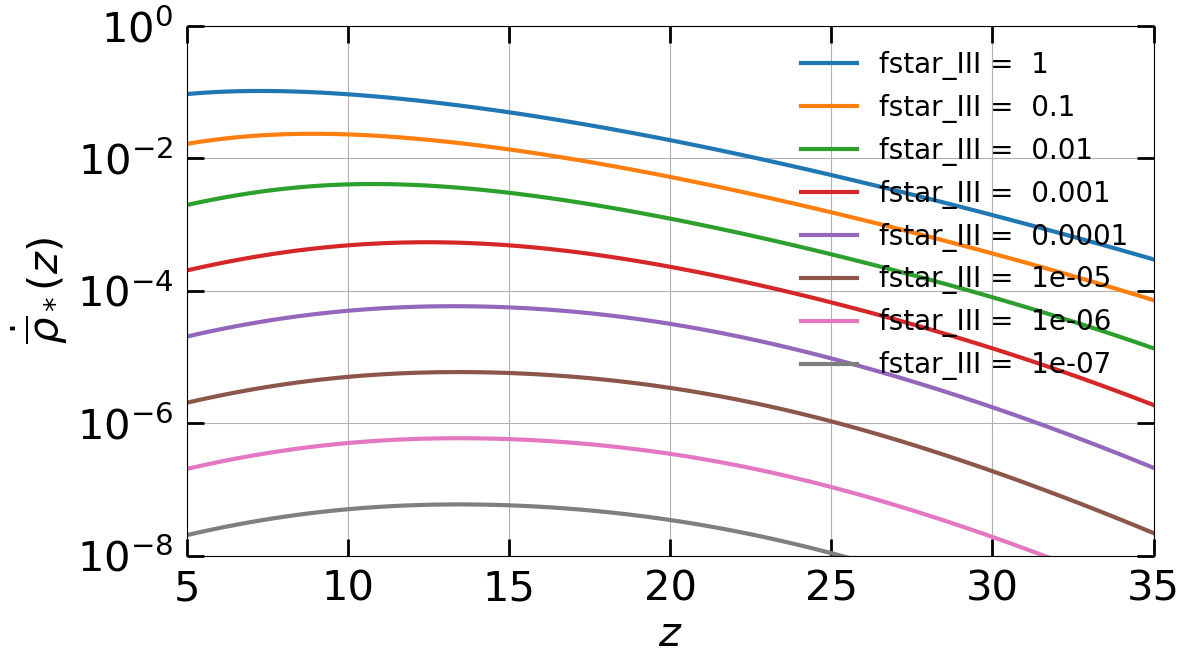

In [1238]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(fstar_III)):
    plt.semilogy(zlist, list1[i].SFRD_III_avg, linewidth=3.0, label='fstar_III =  %s' % fstar_III[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

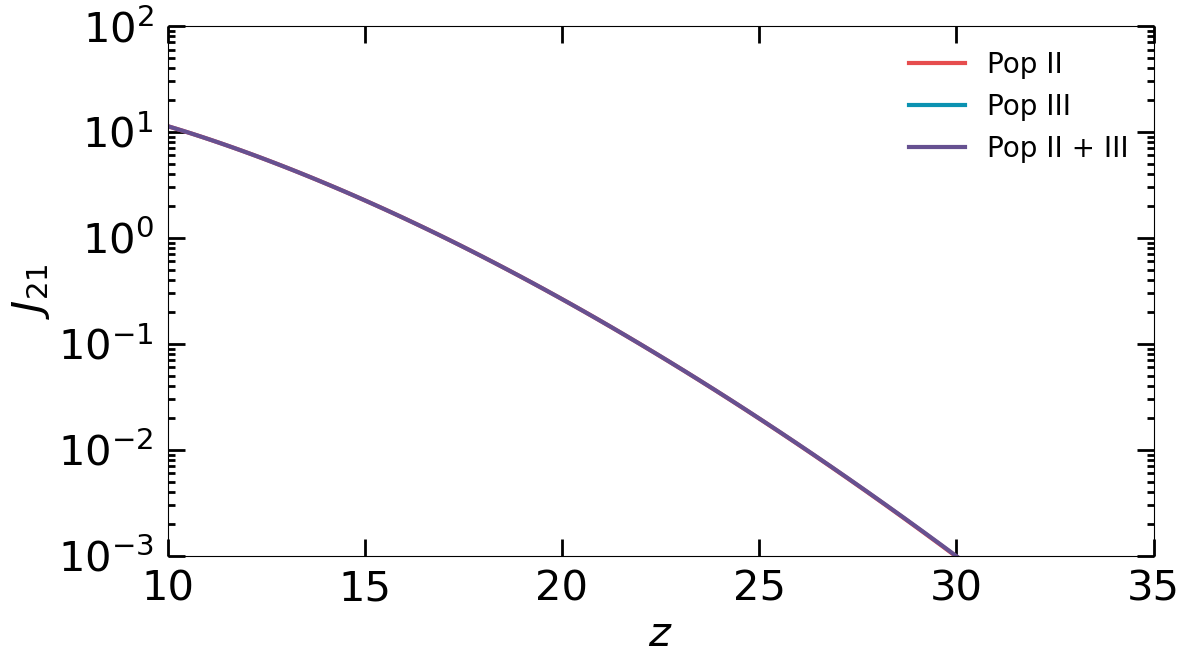

In [1239]:
plt.figure(figsize = (12, 6.75))

plt.semilogy(CoeffStructure.zintegral, CoeffStructure.J_21_LW_II, color="#E64D4E", linewidth=3.0, label = 'Pop II')
plt.semilogy(CoeffStructure.zintegral, CoeffStructure.J_21_LW_III, color="#0B92B1", linewidth=3.0, label = 'Pop III')

plt.semilogy(CoeffStructure.zintegral, CoeffStructure.J_21_LW_II + CoeffStructure.J_21_LW_III, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([10, 35])
plt.ylim(1e-3, 1e2)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$J_{21}$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.show()

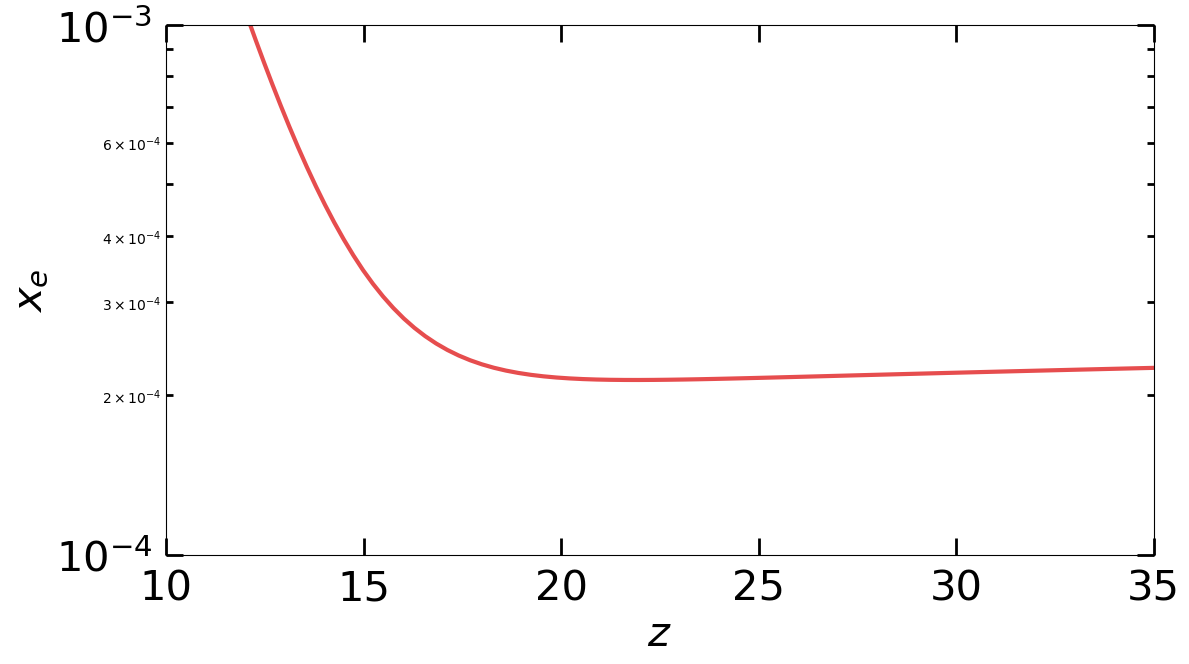

In [1240]:
plt.figure(figsize = (12, 6.75))

plt.semilogy(CoeffStructure.zintegral,CoeffStructure.xe_avg, color="#E64D4E", linewidth=3.0)

plt.xlim([10, 35])
plt.ylim([1e-4, 1e-3])

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$x_e$', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
# plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.show()

## Step 4: Fluctuations

The last structure to run is Power_Spectra, which uses our lognormal and log-chisquare prescription to compute the statistics of IGM fluctuations in the form of two-point functions.

In [1241]:
RSDMODE = 1

PS21 = zeus21.Power_Spectra(UserParams, CosmoParams, AstroParams, ClassyCosmo, CorrFClass, CoeffStructure, RSD_MODE = RSDMODE)
klist = CorrFClass._klistCF

## Plotting Results

In [1242]:
from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((zlist, klist), PS21.Deltasq_T21, method = 'cubic', bounds_error=False, fill_value=0)
interpLin = RegularGridInterpolator((zlist, klist), PS21.Deltasq_T21_lin, method = 'cubic', bounds_error=False, fill_value=0)

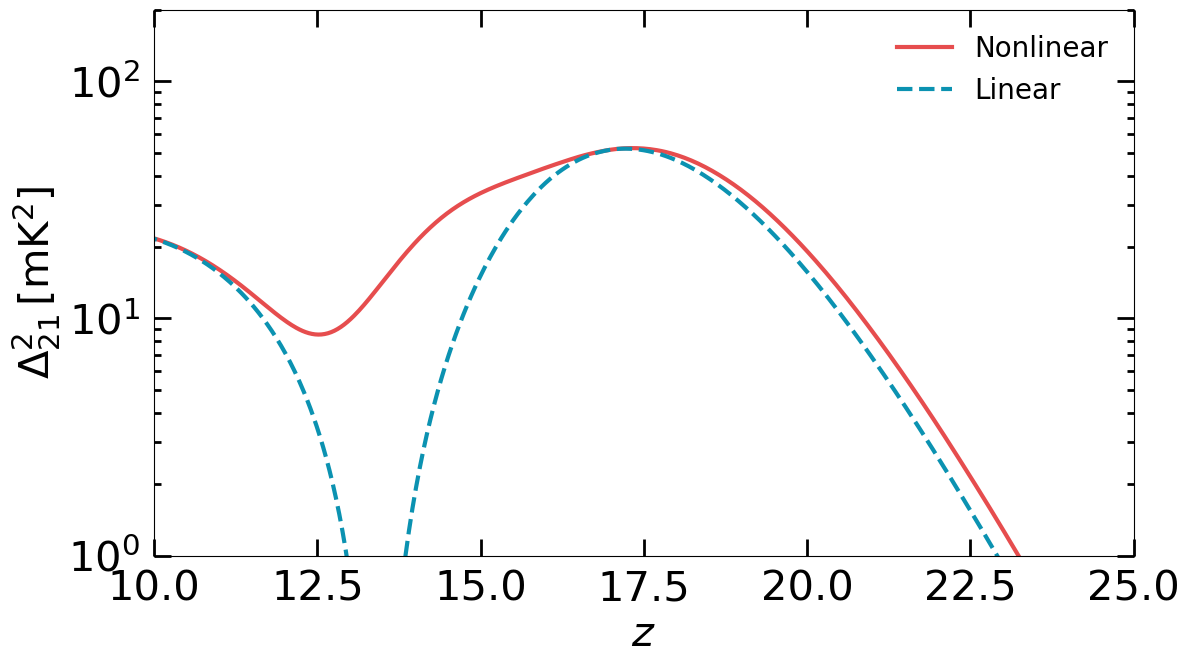

In [1243]:
#choose a z to plot
kchoose=0.3 
zlistHighRes = np.geomspace(zlist[0], zlist[-1], 1000)

powerSpectrum = interp((zlistHighRes, kchoose))
powerSpectrumLin = interpLin((zlistHighRes, kchoose))

plt.figure(figsize = (12, 6.75))

plt.semilogy(zlistHighRes, powerSpectrum, color="#E64D4E", linewidth=3.0, label = 'Nonlinear')
plt.semilogy(zlistHighRes, powerSpectrumLin, color="#0B92B1", linewidth=3.0, linestyle = 'dashed', label = 'Linear')

plt.xlim([10, 25])
plt.ylim([1,200])

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()

plt.show()

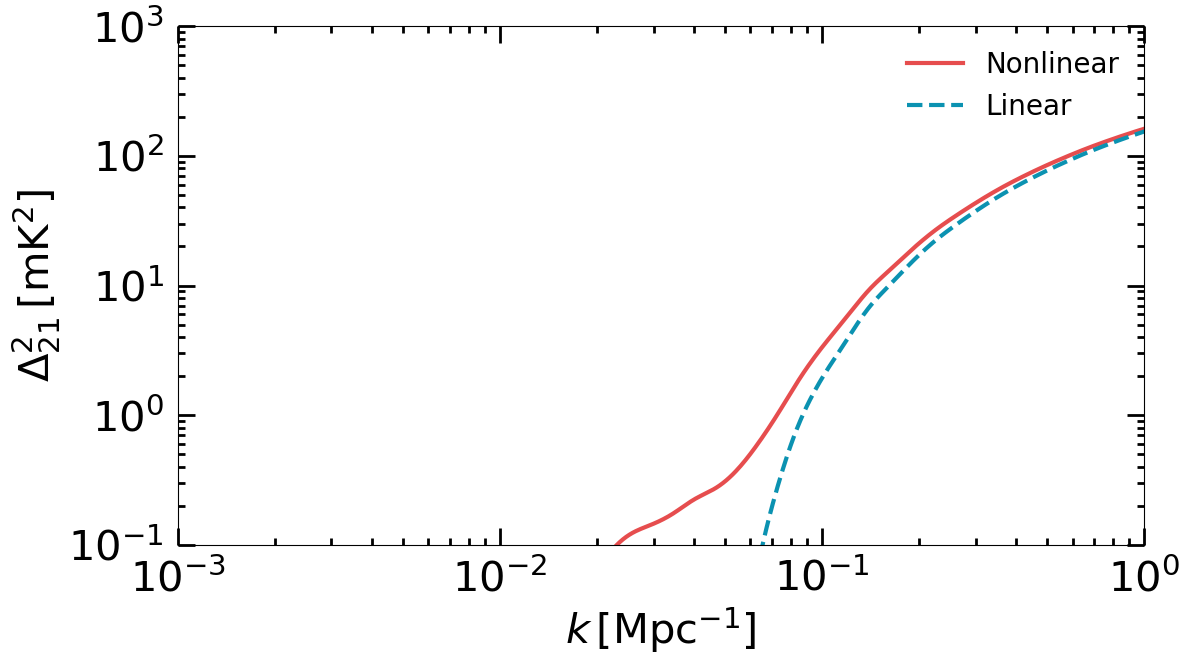

In [1244]:
#choose a z to plot
zchoose=16
klistHighRes = np.geomspace(1e-4, 1e1, 1000)

powerSpectrum = interp((zchoose, klistHighRes))
powerSpectrumLin = interpLin((zchoose, klistHighRes))

plt.figure(figsize = (12, 6.75))

plt.loglog(klistHighRes, powerSpectrum, color="#E64D4E", linewidth=3.0, label = 'Nonlinear')
plt.loglog(klistHighRes, powerSpectrumLin, color="#0B92B1", linewidth=3.0, linestyle = 'dashed', label = 'Linear')

plt.xlim([1e-3,1e0])
plt.ylim([1e-1,1e3])

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$', fontsize = 30)
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()

plt.show()

For questions, don't hesitate to reach out to hcruz2@jhu.edu!

## Variation av parametrar

I varied fstar_III above and I now vary the rest of the Pop III quantities! Obs! Each time I vary a new parameter, I need to reset the value of the last varied parameter to its fiducial value!

### alphastar_III

In [1245]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = [-100, -3,-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 100] 
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35), 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8


#set up your astro parameters too, here the peak of f*(Mh) as an example
list2 = []

for i in range(len(alphastar_III)):


        AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III[i], 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
        CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
        list2.append(CoeffStructure)

print('SFRD and coefficients stored. Move ahead.')

/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:695: RuntimeWarning: overflow encountered in power
  /(pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.alphastar_III) + pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.betastar_III))


SFRD and coefficients stored. Move ahead.


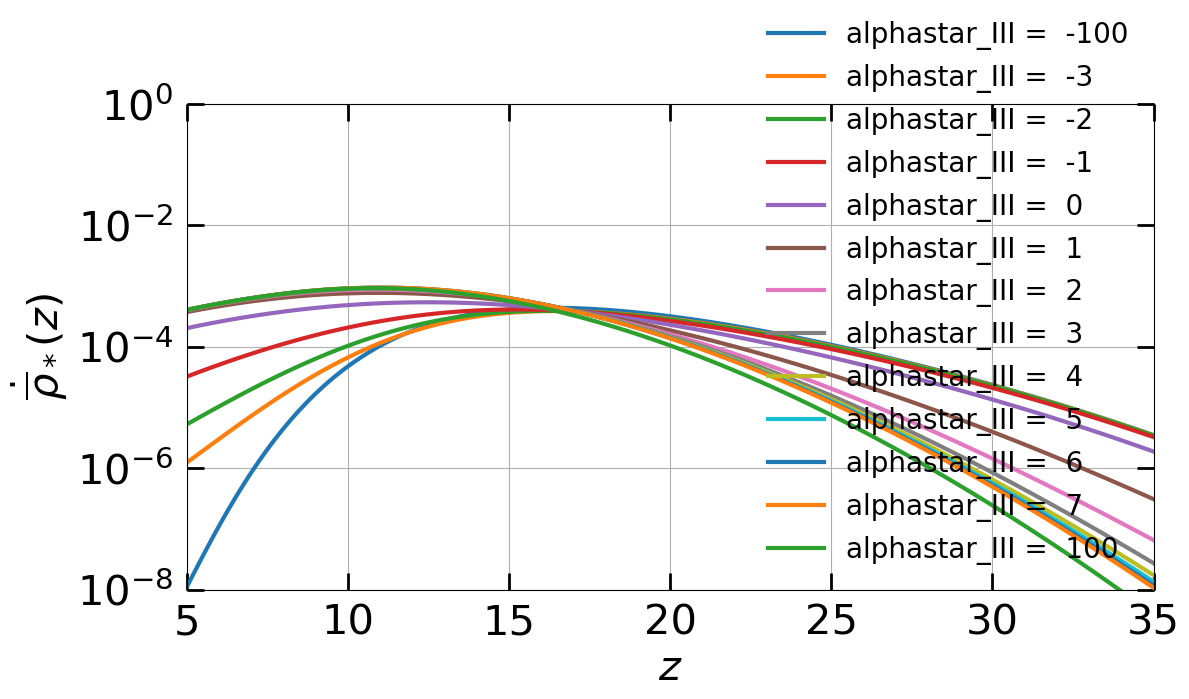

In [1246]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(alphastar_III)):
    plt.semilogy(zlist, list2[i].SFRD_III_avg, linewidth=3.0, label='alphastar_III =  %s' % alphastar_III[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### betastar_III

In [1247]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = [-100, -3,-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 100]
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35), 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list3 = []

for i in range(len(betastar_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III[i],
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list3.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')

SFRD and coefficients stored. Move ahead.


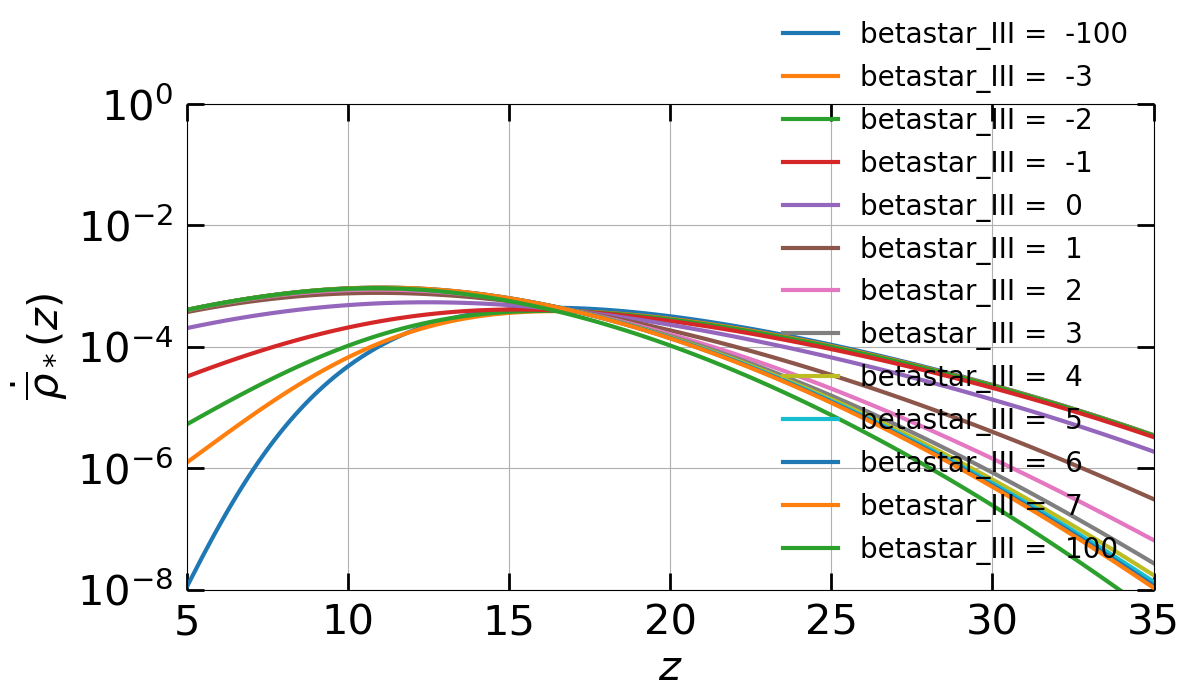

In [1248]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(betastar_III)):
    plt.semilogy(zlist, list3[i].SFRD_III_avg, linewidth=3.0, label='betastar_III =  %s' % betastar_III[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### Mc_III

In [1249]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = [0, 1e6, 1e7, 1e8, 1e19]
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35), 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list4 = []

for i in range(len(Mc_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III[i],
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list4.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')

/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:695: RuntimeWarning: divide by zero encountered in divide
  /(pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.alphastar_III) + pow(Mhlist/Astro_Parameters.Mc_III, -Astro_Parameters.betastar_III))


SFRD and coefficients stored. Move ahead.


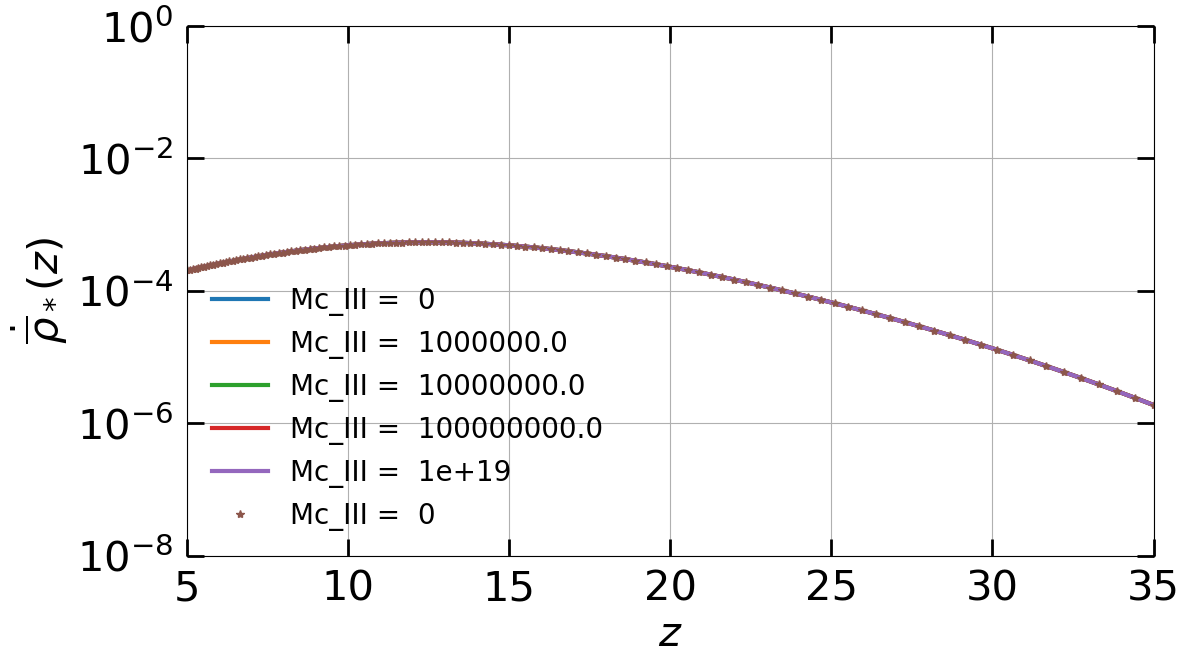

In [1250]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(Mc_III)):
    plt.semilogy(zlist, list4[i].SFRD_III_avg, linewidth=3.0, label='Mc_III =  %s' % Mc_III[i])
plt.semilogy(zlist, list4[0].SFRD_III_avg, '*', linewidth=3.0, label='Mc_III =  %s' % Mc_III[0])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### dlog10epsstardz_III

In [1251]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = [-2, -1, 0.0, 1, 2, 10]

fesc7_III = 10**(-1.35), 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list5 = []

for i in range(len(dlog10epsstardz_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III[i],

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list5.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')

/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:692: RuntimeWarning: overflow encountered in power
  epsstar_ofz_III = Astro_Parameters.fstar_III * 10**(Astro_Parameters.dlog10epsstardz_III * (z-Astro_Parameters._zpivot_III) )


SFRD and coefficients stored. Move ahead.


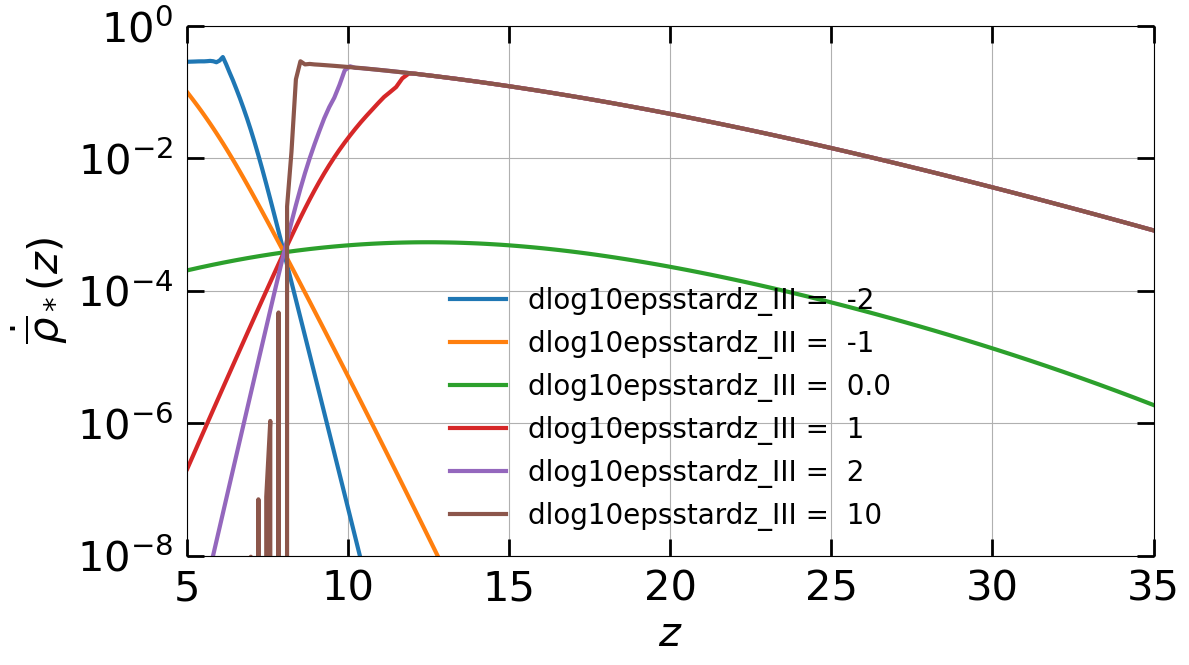

In [1252]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(dlog10epsstardz_III)):
    plt.semilogy(zlist, list5[i].SFRD_III_avg, linewidth=3.0, label='dlog10epsstardz_III =  %s' % dlog10epsstardz_III[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### fesc7_III

In [1253]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = [10**(-1.3), 10**(-1.35), 10**(-1.4), 10**(-4)] 
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list6 = []

for i in range(len(fesc7_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III[i],
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list6.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


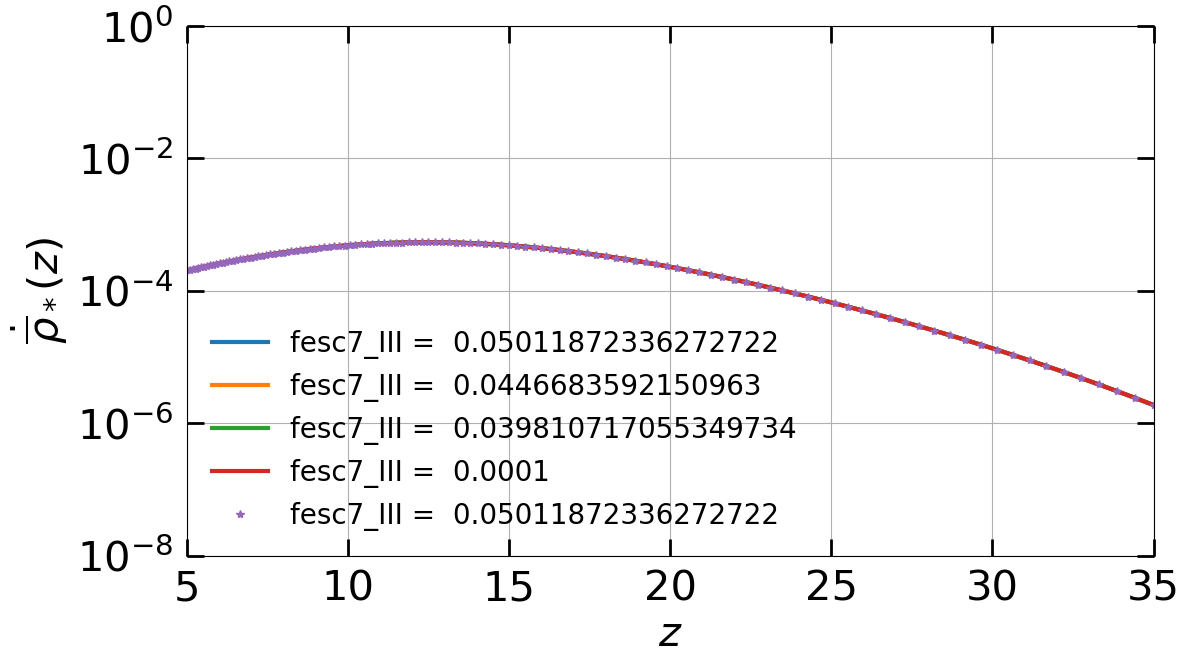

In [1254]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(fesc7_III)):
    plt.semilogy(zlist, list6[i].SFRD_III_avg, linewidth=3.0, label='fesc7_III =  %s' % fesc7_III[i])
plt.semilogy(zlist, list6[0].SFRD_III_avg, '*', linewidth=3.0, label='fesc7_III =  %s' % fesc7_III[0])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### alphaesc_III

In [1255]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = [-0.8, -0.3, 0.2, 10]
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list7 = []

for i in range(len(alphaesc_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III[i],
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list7.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


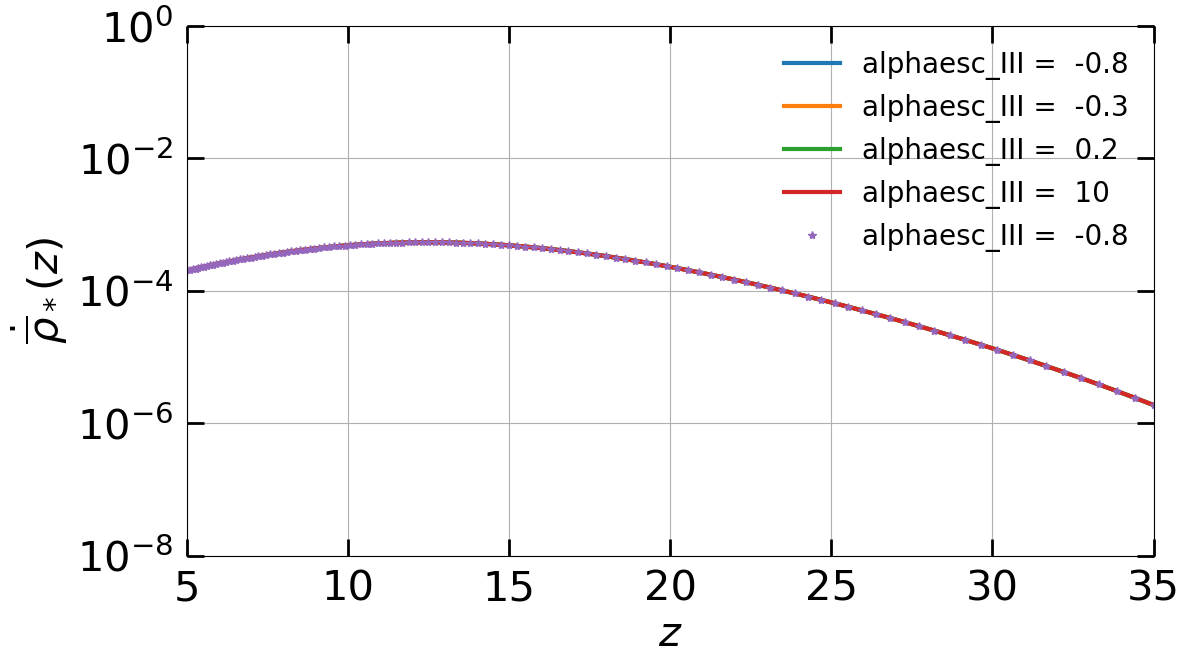

In [1256]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(alphaesc_III)):
    plt.semilogy(zlist, list7[i].SFRD_III_avg, linewidth=3.0, label='alphaesc_III =  %s' % alphaesc_III[i])
plt.semilogy(zlist, list7[0].SFRD_III_avg, '*', linewidth=3.0, label='alphaesc_III =  %s' % alphaesc_III[0])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### L40_xray_III

In [1257]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = [10**0, 10**0.5, 10**1, 10**5]
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list8 = []

for i in range(len(L40_xray_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III[i],
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list8.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


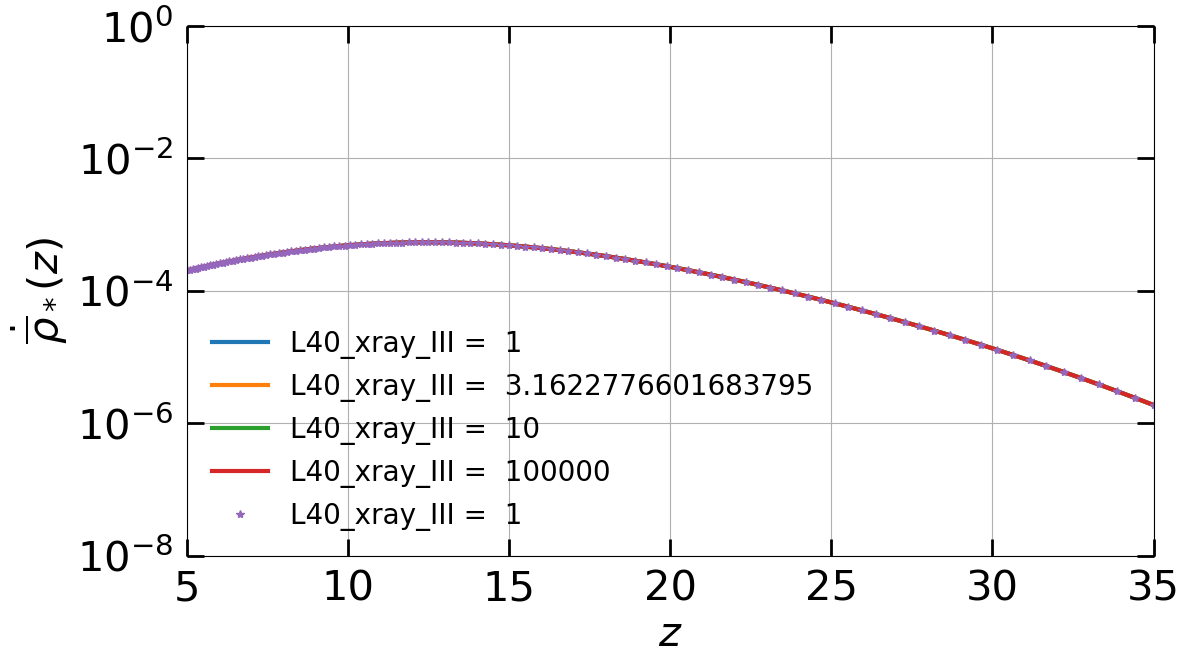

In [1258]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(L40_xray_III)):
    plt.semilogy(zlist, list8[i].SFRD_III_avg, linewidth=3.0, label='L40_xray_III =  %s' % L40_xray_III[i])
plt.semilogy(zlist, list8[0].SFRD_III_avg, '*', linewidth=3.0, label='L40_xray_III =  %s' % L40_xray_III[0])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### alpha_xray_III

In [1259]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = [-2, -1.0, 0, 10]


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list9 = []

for i in range(len(alpha_xray_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III[i],
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list9.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


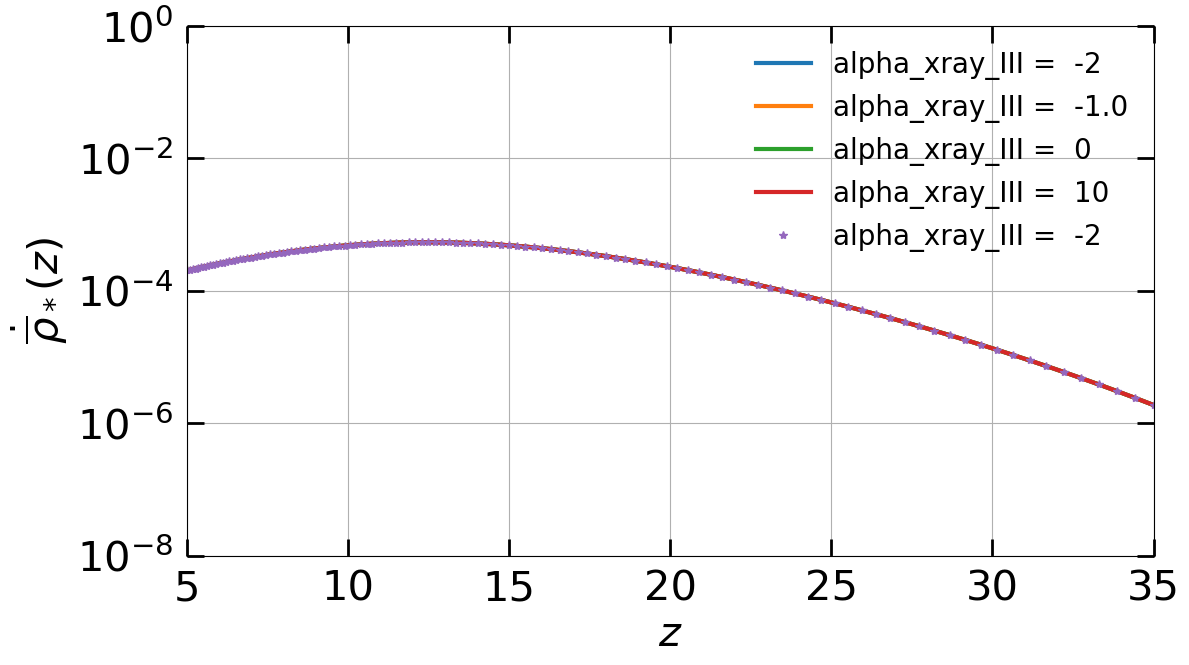

In [1260]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(alpha_xray_III)):
    plt.semilogy(zlist, list9[i].SFRD_III_avg, linewidth=3.0, label='alpha_xray_III =  %s' % alpha_xray_III[i])
plt.semilogy(zlist, list9[0].SFRD_III_avg, '*', linewidth=3.0, label='alpha_xray_III =  %s' % alpha_xray_III[0])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### A_LW

In [1261]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = [0, 1, 2.0, 3, 4, 5, 6, 7]
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list10 = []

for i in range(len(A_LW)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW[i],
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list10.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


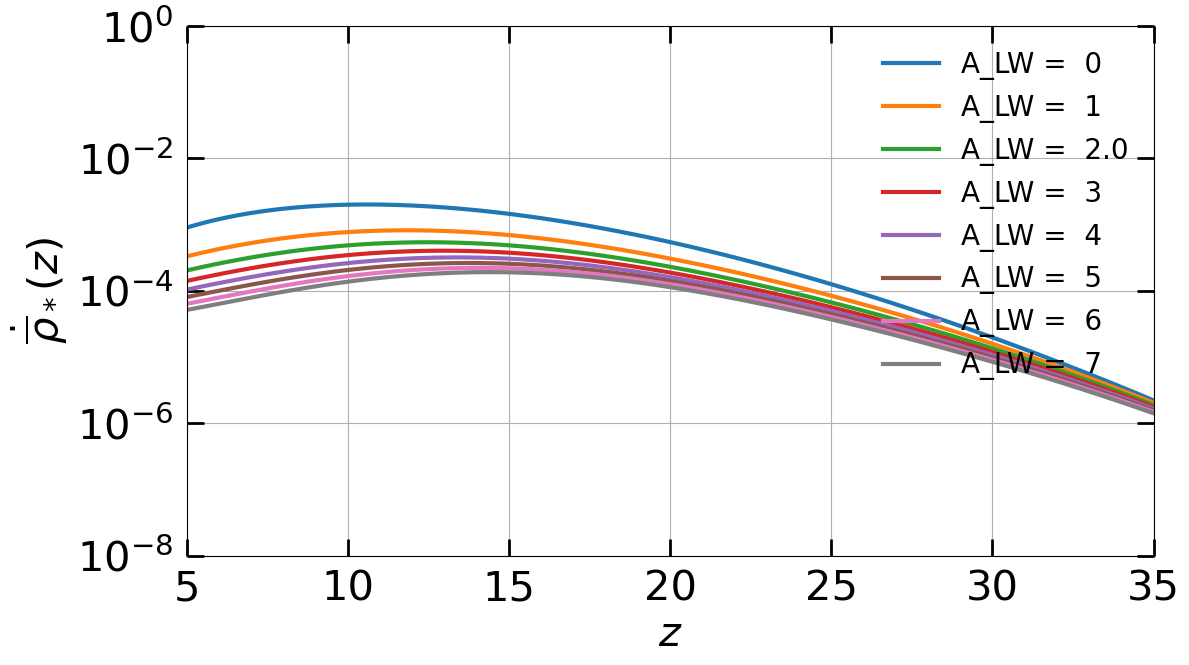

In [1262]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(A_LW)):
    plt.semilogy(zlist, list10[i].SFRD_III_avg, linewidth=3.0, label='A_LW =  %s' % A_LW[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### beta_LW

In [1263]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = [-30, -2, -1, 0, 0.6, 1, 2, 3, 4]

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list11 = []

for i in range(len(beta_LW)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW[i],
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list11.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')
print('Observation: At beta_LW=5 the runtime increases indefinitely')


/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:675: RuntimeWarning: divide by zero encountered in power
  lwFeedback = 1 + Astro_Parameters.A_LW*pow(J21LW_interp(z), Astro_Parameters.beta_LW)
/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:675: RuntimeWarning: overflow encountered in power
  lwFeedback = 1 + Astro_Parameters.A_LW*pow(J21LW_interp(z), Astro_Parameters.beta_LW)
/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:148: RuntimeWarning: divide by zero encountered in divide
  if max(SFRD_III_Iter_Matrix[-1]/SFRD_III_Iter_Matrix[-2]) < 1.0 + errorTolerance and min(SFRD_III_Iter_Matrix[-1]/SFRD_III_Iter_Matrix[-2]) > 1.0 - errorTolerance:
/opt/anaconda3/lib/python3.12/site-packages/zeus21/sfrd.py:148: RuntimeWarning: invalid value encountered in divide
  if max(SFRD_III_Iter_Matrix[-1]/SFRD_III_Iter_Matrix[-2]) < 1.0 + errorTolerance and min(SFRD_III_Iter_Matrix[-1]/SFRD_III_Iter_Matrix[-2]) > 1.0 - errorTolerance:
/opt/anaconda3/lib/python3.12/sit

SFRD and coefficients stored. Move ahead.
Observation: At beta_LW=5 the runtime increases indefinitely


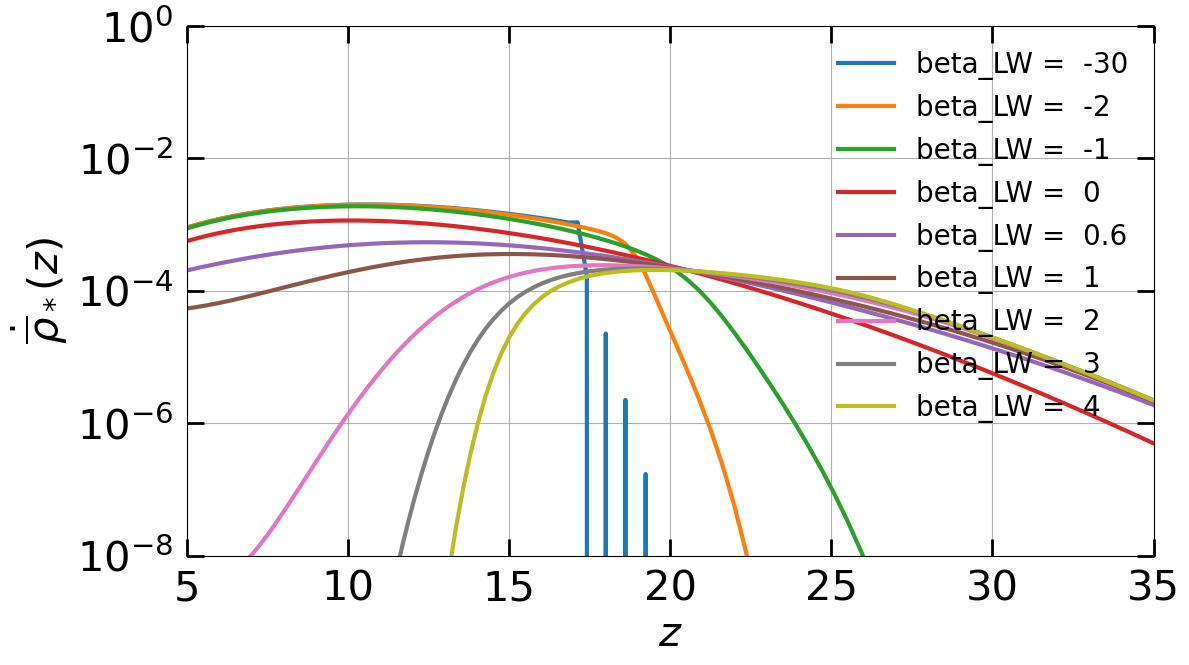

In [1264]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(beta_LW)):
    plt.semilogy(zlist, list11[i].SFRD_III_avg, linewidth=3.0, label='beta_LW =  %s' % beta_LW[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### A_vcb

In [1265]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = [0, 1.0, 2, 3, 4, 5, 6, 7, 30]
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list12 = []

for i in range(len(A_vcb)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb[i],
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list12.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


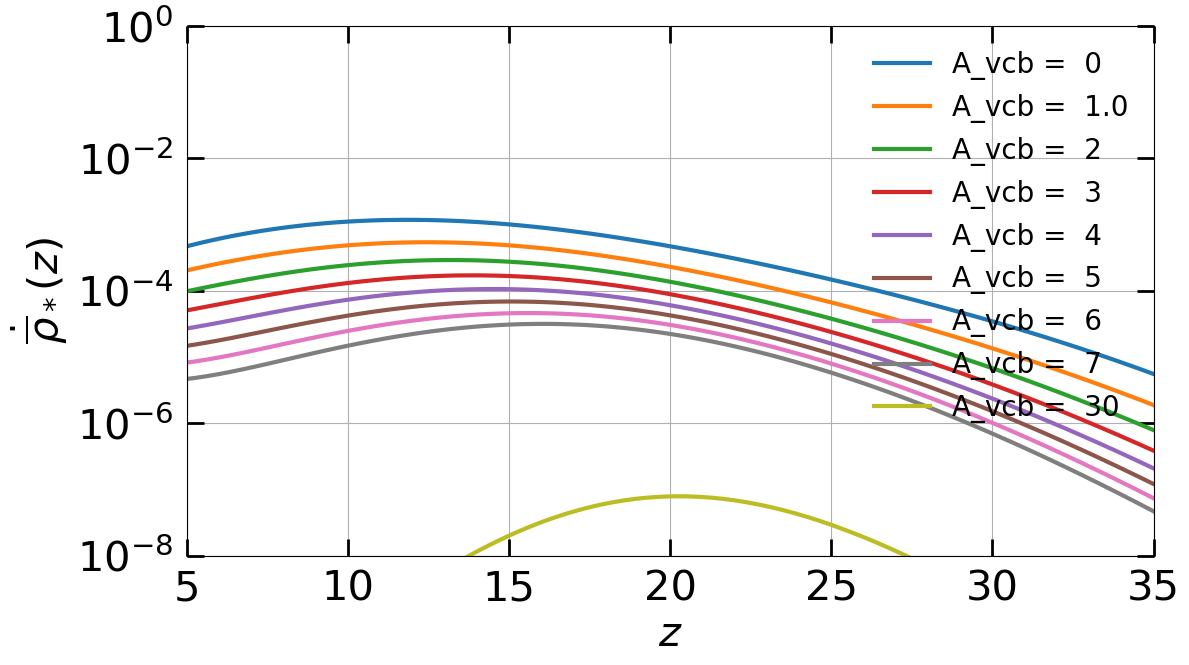

In [1266]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(A_vcb)):
    plt.semilogy(zlist, list12[i].SFRD_III_avg, linewidth=3.0, label='A_vcb =  %s' % A_vcb[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### beta_vcb

In [1267]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = [-10, -2, -1, 0, 1, 1.8, 2, 3, 4, 5, 6, 9]



#set up your astro parameters too, here the peak of f*(Mh) as an example
list13 = []

for i in range(len(beta_vcb)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb[i]
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list13.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


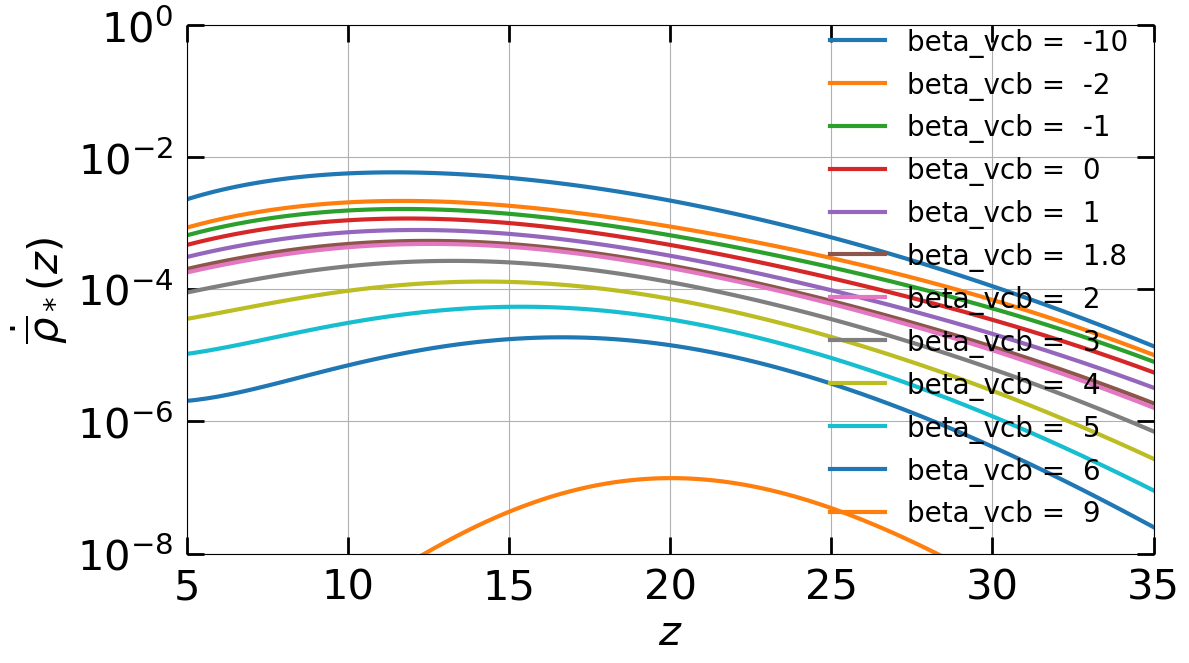

In [1268]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(beta_vcb)):
    plt.semilogy(zlist, list13[i].SFRD_III_avg, linewidth=3.0, label='beta_vcb =  %s' % beta_vcb[i])

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

All parameters under Pop III quantities have been varied. Now lets also test the LyA parameter and the moodel parameters

### Nalpha_lyA_III

In [1269]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = [10000, 15000, 17900, 20000, 25000, 100000]    # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list14 = []

for i in range(len(Nalpha_lyA_III)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III[i],
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list14.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


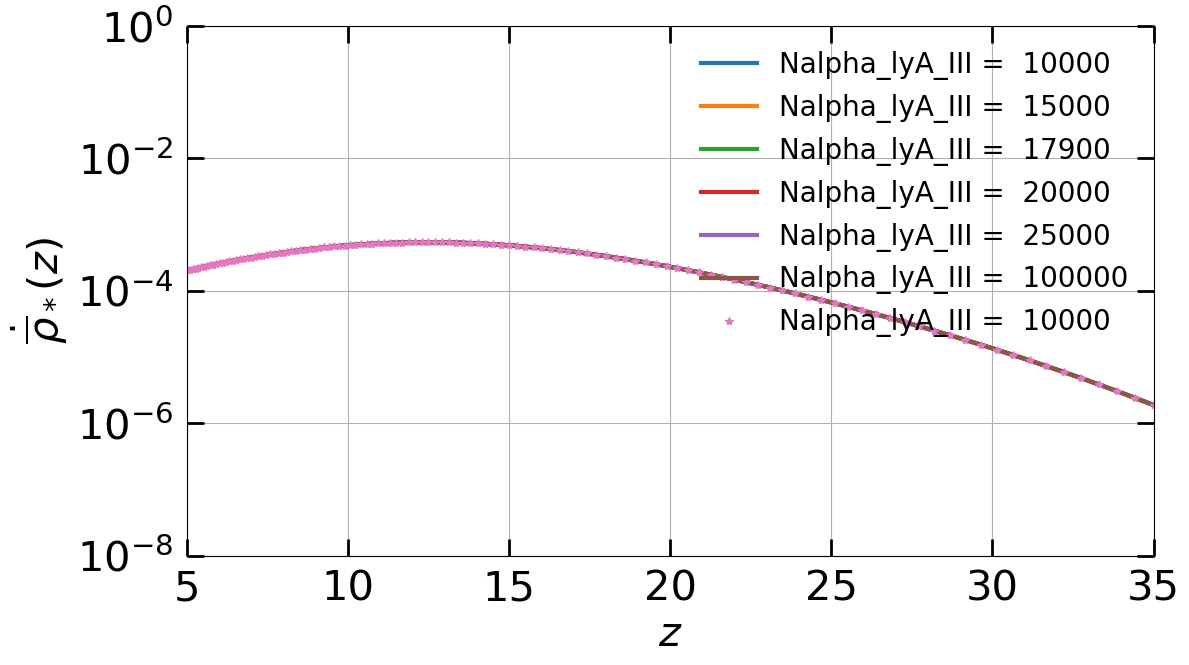

In [1270]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(Nalpha_lyA_III)):
    plt.semilogy(zlist, list14[i].SFRD_III_avg, linewidth=3.0, label='Nalpha_lyA_III =  %s' % Nalpha_lyA_III[i])
plt.semilogy(zlist, list14[0].SFRD_III_avg, '*',linewidth=3.0, label='Nalpha_lyA_III =  %s' % Nalpha_lyA_III[0])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### astromodel

In [1271]:
### POP II quantities first

################################
### Model Parameters
astromodel = [0, 1]            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = 0       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900   # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list15 = []

for i in range(len(astromodel)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel[i], 
                                        accretion_model = accretion_model,
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list15.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


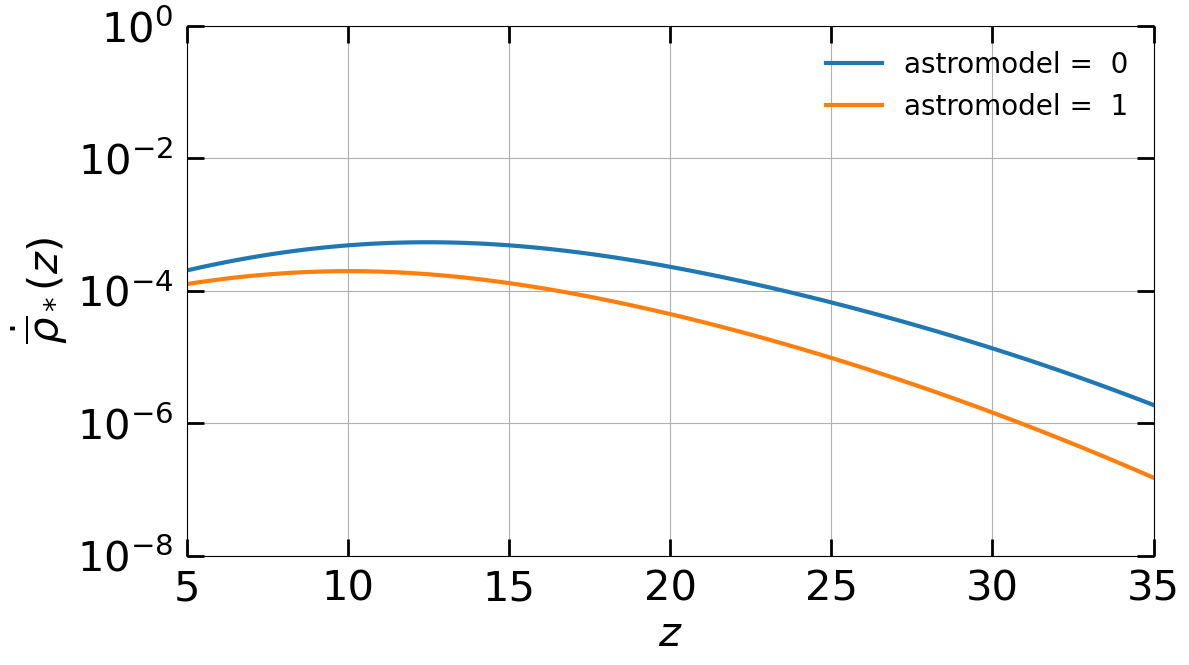

In [1272]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(astromodel)):
    plt.semilogy(zlist, list15[i].SFRD_III_avg, linewidth=3.0, label='astromodel =  %s' % astromodel[i])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()

### accretion_model

In [1273]:
### POP II quantities first

################################
### Model Parameters
astromodel = 0            # ASTRO MODEL: 0 for GALUMI-like, 1 for 21cmfast-like, default 0
accretion_model = [0, 1]       # ACCRETION MODEL: 0 for exponential, 1 for EPS, default EXP

################################
### SFR(Mh) Parameteres
alphastar = 0.5          # alphastar powerlaw index for low masses, default 0.5
betastar = -0.5           # betastar powerlaw index for high masses, default -0.5
epsstar = 10**-1.             # epsilonstar = fstar at Mc
Mc = 3e11                 # Pivot mass at which the power law cuts for model 0, default Mc = 3e11
dlog10epsstardz = 0.0     # dlog10epsilonstar/dz, default 0

################################
### Escape fraction parameters
fesc10 = 0.1              # fesc(M) parameter. Power law normalized (fesc10) at M=1e10 Msun with index alphaesc
alphaesc = 0.0
L40_xray = 10**0.5        # L40_xray: soft-band (E<2 keV) lum/SFR in Xrays in units of 10^40 erg/s/(Msun/yr)
E0_xray = 500.            # E0_xray: minimum energy in eV
alpha_xray = -1.0         # Xray SED power-law index
Emax_xray_norm=2000       # max energy in eV to normalize SED. Keep at 2000 eV normally

################################
### LyA parameters
Nalpha_lyA_II = 9690      # number of Pop II photons between LyA and Ly Cont. per baryon (from BL05)
Nalpha_lyA_III = 17900   # number of Pop III photons between LyA and Ly Cont. per baryon value of 17900 is from Klessen & Glover 2023 (2303.12500), table A2

################################
### MTURN Parameters: 
Mturn_fixed = None        # Mturn_fixed: None if use Matom(z) at each z, Some value if fixed Mturn
FLAG_MTURN_SHARP= False   # Mturn_sharp: False if regular exponential cutoff, True if sharp cutoff, active only if Mturn_fixed is on

################################
### UVLF Parameters
C0dust = 4.43             # DUST PARAMETERS FOR UVLFs
C1dust = 1.99
sigmaUV = 0.5             # stochasticity (gaussian rms) in the halo-galaxy connection P(MUV | Mh) - TODO: only used in UVLF not sfrd

################################
ZMIN = 5.0               # down to which z we compute the evolution



################################
# Pop III Quantities
alphastar_III = 0
betastar_III = 0
fstar_III = 10**(-3)
Mc_III = 1e7
dlog10epsstardz_III = 0.0

fesc7_III = 10**(-1.35)
alphaesc_III = -0.3
L40_xray_III = 10**0.5
alpha_xray_III = -1.0


USE_POPIII = True
USE_LW_FEEDBACK = True

A_LW = 2.0
beta_LW = 0.6

A_vcb = 1.0
beta_vcb = 1.8



#set up your astro parameters too, here the peak of f*(Mh) as an example
list16 = []

for i in range(len(accretion_model)):

    AstroParams = zeus21.Astro_Parameters(UserParams,
                                        CosmoParams, 
                                        astromodel = astromodel, 
                                        accretion_model = accretion_model[i],
                                        
                                        alphastar = alphastar, 
                                        betastar = betastar, 
                                        epsstar = epsstar, 
                                        Mc = Mc, 
                                        dlog10epsstardz = dlog10epsstardz,
                                        
                                        fesc10 = fesc10, 
                                        alphaesc = alphaesc,
                                        L40_xray = L40_xray, 
                                        E0_xray = E0_xray, 
                                        alpha_xray = alpha_xray, 
                                        Emax_xray_norm = Emax_xray_norm, 
                                        
                                        Nalpha_lyA_II = Nalpha_lyA_II, 
                                        Nalpha_lyA_III = Nalpha_lyA_III,
                                        
                                        Mturn_fixed = Mturn_fixed, 
                                        FLAG_MTURN_SHARP = FLAG_MTURN_SHARP,

                                        C0dust = C0dust, 
                                        C1dust = C1dust,
                                        sigmaUV = sigmaUV,
                                        
                                        
                                        USE_POPIII = USE_POPIII, 
                                        USE_LW_FEEDBACK = USE_LW_FEEDBACK,

                                        alphastar_III = alphastar_III, 
                                        betastar_III = betastar_III,
                                        fstar_III = fstar_III,
                                        Mc_III = Mc_III,
                                        dlog10epsstardz_III = dlog10epsstardz_III,

                                        fesc7_III = fesc7_III,
                                        alphaesc_III = alphaesc_III,
                                        L40_xray_III = L40_xray_III,
                                        alpha_xray_III = alpha_xray_III,
                                                
                                        A_LW = A_LW,
                                        beta_LW = beta_LW,
                                        
                                        A_vcb = A_vcb,
                                        beta_vcb = beta_vcb
                                                )
    CoeffStructure = zeus21.get_T21_coefficients(UserParams, CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
    list16.append(CoeffStructure)
    
print('SFRD and coefficients stored. Move ahead.')


SFRD and coefficients stored. Move ahead.


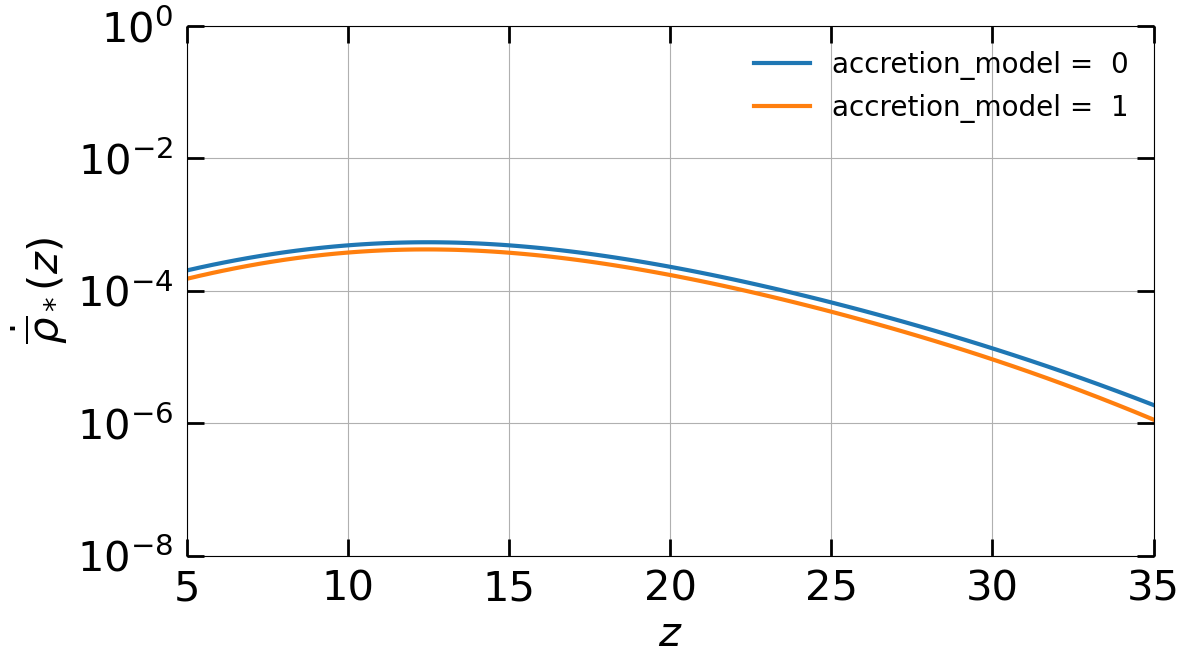

In [1274]:
plt.figure(figsize = (12, 6.75))

# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg, color="#E64D4E", linewidth=3.0, label = 'Pop II')
for i in range(len(accretion_model)):
    plt.semilogy(zlist, list16[i].SFRD_III_avg, linewidth=3.0, label='accretion_model =  %s' % accretion_model[i])
# plt.semilogy(CoeffStructure.zintegral, CoeffStructure.SFRD_II_avg + CoeffStructure.SFRD_III_avg, color="#665191", linewidth=3.0, label = 'Pop II + III')

plt.xlim([5, 35])
plt.ylim(1e-8, 1e-0)

plt.xlabel(r'$z$', fontsize = 30)
plt.ylabel(r'$\dot{\overline{\rho}}_*(z)$', fontsize = 30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params(which='major', length=12, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(which='minor', length=5, width=2, direction='in', top = True, bottom = True, left = True, right = True)
plt.tick_params(axis="y", labelsize=30, pad = 10)
plt.tick_params(axis="x", labelsize=30, pad = 10)
plt.legend(fontsize=20, frameon = False)
plt.tight_layout()
plt.grid()
plt.show()